## Goals

## Libraries

In [1]:
import pandas as pd
import numpy as np
import spacy
import textblob
from gensim.models import word2vec
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels import robust
from string import punctuation

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import SpectralClustering
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# 1. Import and Add Basic Features

In [2]:
review = pd.read_csv('boardgame-comments-sample.csv')
review.columns = 'reviewer_id', 'game_id', 'rating', 'comment'
review.head(2)

,reviewer_id,game_id,rating,comment
0,25308,37111,8.5,++++ Thematic +++ Bluff - Many randomness I ...
1,54313,12,8.0,"""well, that ugly artwork certainly helped imme..."


In [3]:
# RATINGS ADJUSTMENT: ceiling >= .5 [or] floor < .5
review['rating'] = review.rating.apply(round)

In [4]:
# Check for null values
review.isnull().any()

reviewer_id    False
game_id        False
rating         False
comment        False
dtype: bool

In [5]:
# Functions for finding percentage frequency (capital letters/punctuation)
def per_check(string_value, total):
    percentage = len(string_value)
    if percentage != 0:
        percentage = float(total / percentage) * 100
    else:
        percentage = 0
    return percentage

def punc_count(string_value):
    count = 0
    for c in string_value:
        if c in punctuation:
            count+= 1
    return per_check(string_value, count)

def caplet_count(string_value):
    count = 0
    for c in string_value:
        if c.isupper():
            count+= 1
    return per_check(string_value, count)      

review['c_len'] = review.comment.apply(len)
review['punc_count'] = review.comment.apply(punc_count)
review['caplet_count'] = review.comment.apply(caplet_count)

In [6]:
review.head(2)

,reviewer_id,game_id,rating,comment,c_len,punc_count,caplet_count
0,25308,37111,8,++++ Thematic +++ Bluff - Many randomness I ...,407,4.914005,1.719902
1,54313,12,8,"""well, that ugly artwork certainly helped imme...",100,7.000000,2.000000


### Show Reviewer_ID and Game_ID Counts (Matthew's Suggestion)

In [7]:
userreview = review.groupby('reviewer_id')
# dflist = []
# for r in userreview:
#     dflist.append(r[1])  
review.reviewer_id.value_counts()[0:3]

14263    2
61618    2
52258    2
Name: reviewer_id, dtype: int64

In [8]:
gamereview = review.groupby('game_id')
# dflist = []
# for r in gamereview:
#     dflist.append(r[1])  
review.game_id.value_counts()[0:3]

13       16
822      13
24480     9
Name: game_id, dtype: int64

In [9]:
del review['game_id']
del review['reviewer_id']

# 2. Natural Language Processing Features:

## _Spacy_

In [10]:
nlp = spacy.load('en')

In [11]:
%%time
docs = []
tokens = []
lemma = []
pos = []
deps = []
ents = []

def insert_null(l):
    return [(w if w else '0') for w in l]

# Create doc and len features for processing
for doc in nlp.pipe(review['comment'].astype('unicode').values,batch_size = 10, n_threads=4):
    if doc.is_parsed:
        docs.append(doc)
    else:
        # Add blanks if parse fails
        docs.append(None)
        
review['doc'] = docs
review['w_len'] = review.doc.apply(len)

CPU times: user 10.8 s, sys: 1.44 s, total: 12.3 s
Wall time: 6.31 s


In [12]:
# apply features
review['tokens'] = review.doc.apply(lambda doc: insert_null([tok.text for tok in doc]))
review['lemma'] = review.doc.apply(lambda doc: insert_null([tok.lemma_ for tok in doc]))
review['pos'] = review.doc.apply(lambda doc: insert_null([tok.pos_ for tok in doc]))
review['deps'] = review.doc.apply(lambda doc: insert_null([tok.dep_ for tok in doc]))
review['ents'] = review.doc.apply(lambda doc: insert_null([tok.ent_type_ for tok in doc]))

In [13]:
review.c_len.max()
print(review.comment[review.c_len == 7977].iloc[0][0:300],end=''); print('...')

[u]The Positive:[/u] (+) The art is not 'great', but it sure is very functional. It supports in understanding the game. Moreover, the components are of good quality (except an unfortunate misprint of some 1$-coins in which some are smaller than others)  (+) The game rules are very structured and lim...


## _TextBlob_

In [14]:
%%time
blobs = review.comment.apply(lambda val: textblob.TextBlob(val))

CPU times: user 19.8 ms, sys: 409 µs, total: 20.2 ms
Wall time: 10.5 ms


In [15]:
review['sent_pol'] = blobs.apply(lambda val: val.sentiment[0])
review['sent_subj'] = blobs.apply(lambda val: val.sentiment[1])

_Pol = Sentiment Polarity (positive or negative word choice)_ <br>
_Subj = Sentiment Subjectivity (objective or subjective word choice)_

In [16]:
# DataFrame With New Spacy and TextBlob Features
review.tail(1)

,rating,comment,c_len,punc_count,caplet_count,doc,w_len,tokens,lemma,pos,deps,ents,sent_pol,sent_subj
846,7,The vanilla version of this game has it's flaw...,144,3.472222,2.083333,"(The, vanilla, version, of, this, game, has, i...",35,"[The, vanilla, version, of, this, game, has, i...","[the, vanilla, version, of, this, game, have, ...","[DET, NOUN, NOUN, ADP, DET, NOUN, VERB, PRON, ...","[det, compound, nsubj, prep, det, pobj, ROOT, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.05,0.45


# 3. Visuals

In [17]:
def MEDIAN_reject_outliers(data, m=3):
    data = data[abs(data - np.median(data)) < m*robust.mad(data)]
    return data[~np.isnan(data)].sort_values()


def MEAN_reject_outliers(data, m=3):
    data = data[abs(data - np.mean(data)) <= m*np.std(data)]
    return data[~np.isnan(data)].sort_values()

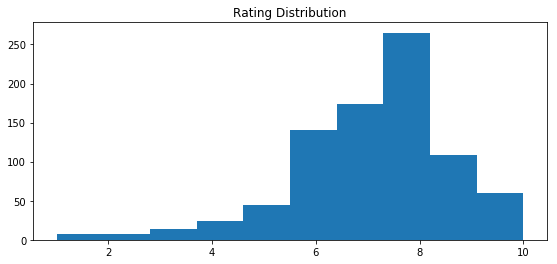

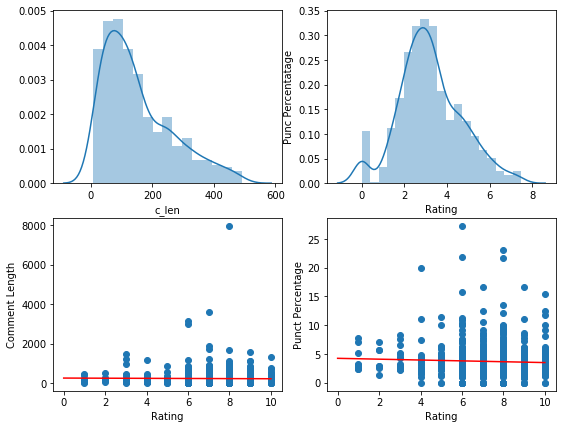

In [18]:
# Ratings
plt.figure(figsize=(9.2,4))
plt.hist(review.rating,bins=10)
plt.title('Rating Distribution')
plt.show()

plt.figure(figsize=(9,7))

plt.subplot(221)
sns.distplot(MEDIAN_reject_outliers(review.c_len))
# plt.title('Average Char Length');

plt.subplot(222)
sns.distplot(MEDIAN_reject_outliers(review.punc_count))
plt.xlabel('Rating');
plt.ylabel('Punc Percentatage');


plt.subplot(223)
plt.scatter(review.rating,review.c_len)
plt.xlabel('Rating')
plt.ylabel('Comment Length')
xlist = []
ylist = []
m,b = np.polyfit(review.rating, review.c_len, 1)
for i in range(0,11):
    ylist.append(i*m + b)
    xlist.append(i)
plt.plot(xlist,ylist,color='r')
# plt.title('Ratings by Review Len')


plt.subplot(224)
plt.scatter(review.rating,review.punc_count);
xlist = []
ylist = []
m,b = np.polyfit(review.rating, review.punc_count, 1)
for i in range(0,11):
    ylist.append(i*m + b)
    xlist.append(i)
plt.plot(xlist,ylist,color='r')
# plt.title('Ratings by Punctuation Percentage');
plt.xlabel('Rating');
plt.ylabel('Punct Percentage');

# 4. Models

In [19]:
features = ['c_len','caplet_count','punc_count','rating','sent_pol','sent_subj']

In [20]:
%%time
all_data = review[features].dropna()
y = all_data['rating'].values.reshape(-1, 1).ravel()
X = all_data[all_data.columns[~all_data.columns.str.contains('rating')]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# svd.transform()

CPU times: user 7.19 ms, sys: 1.54 ms, total: 8.73 ms
Wall time: 7.51 ms


### _Cluster Model_

_Tries to find clusters in the data but doesnt predict anything_ (Not currently relevant)

In [21]:
# Principal Components Analysis PCA (reduces features to 2 for visualization)
pca = PCA(n_components=2)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)

# We know we're looking for three clusters.
n_clusters=10

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train_pca)

#Predicted clusters.
predict=sc.fit_predict(X_train_pca)

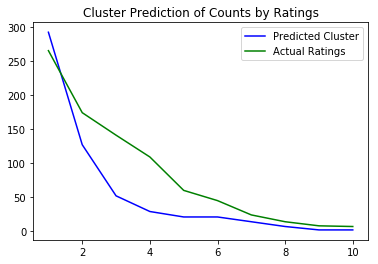

In [22]:
X_train_pca_df = pd.DataFrame(X_train_pca)
X_train_pca_df.columns = ['comp_1','comp_2']
X_train_pca_df['hue'] = predict

plt.plot([i for i in range(1,11)],list(X_train_pca_df.hue.value_counts()),color ='b');
plt.plot([i for i in range(1,11)],list(review.rating.value_counts()),color ='g');
plt.legend(['Predicted Cluster','Actual Ratings']);
plt.title('Cluster Prediction of Counts by Ratings')
plt.show()

<Figure size 1584x1584 with 0 Axes>

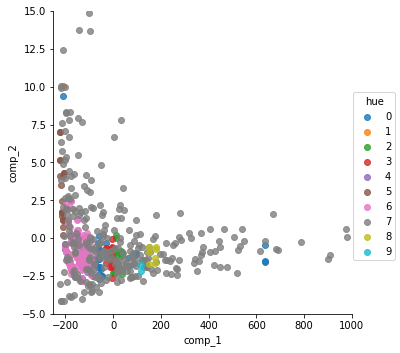

In [23]:
plt.figure(figsize=(22,22));
sns.lmplot(x='comp_1',y='comp_2', hue='hue',data=X_train_pca_df,fit_reg=False)
plt.xlim(-250,1000)
plt.ylim(-5,15)
plt.show()

### _Logistic Regression_

_Operates on probabilities_

In [24]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
print('Check for overfitting:')
print(lr.score(X_train,y_train)*100)
print('')
# Print Model Score Estimation on Same Data
print('Percentage of ratings guessed correctly:')
print(lr.score(X_test,y_test)*100)

Check for overfitting:
31.393298059964724

Percentage of ratings guessed correctly:
30.357142857142854
